# Feature evolution

## 1 Setup

Flags

In [1]:
SAVE_FIGURES = False

Setup the database

In [2]:
import os, sys
sys.path.insert(1, os.path.abspath('..'))
from utils import setup_spreadr

FIG = os.path.join(os.path.abspath(os.path.curdir), '{}.png')
DB_NAME = 'spreadr' + os.path.split(os.path.abspath(os.path.curdir))[1][9:]
setup_spreadr(DB_NAME)
print('Database:', DB_NAME)

Database: spreadr_exp_2


Imports for the analysis

In [3]:
from itertools import combinations

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.patches import Patch
import pandas as pd
import numpy as np
from scipy import stats
from scipy.spatial import distance
import seaborn as sb
import spacy

from gists.models import Sentence, Tree, GistsConfiguration

from utils import memoized, mpl_palette

config = GistsConfiguration.get_solo()

Equip models with useful tools

In [4]:
from utils import equip_spreadr_models as utils_equip
utils_equip()

from linguistics import equip_spreadr_models as linguistics_equip
linguistics_equip()

And create our spaCy instance (only run this once! It's a memory hog)

In [5]:
nlp = spacy.load('en')

## 2 Sentence feature evolution

Add to this:
* 1-, 2-, 3-gram lexical, POS, and dependencies language model likelihood
* Semantic relatedness of content words

In [6]:
@memoized
def depth_under_token(tok):
    children_depths = [depth_under_token(child)
                       for child in tok.children]
    return 0 if len(children_depths) == 0 else 1 + np.max(children_depths)

def dep_depth(doc):
    return depth_under_token([tok for tok in doc if tok.head == tok][0])

def relatedness(doc):
    return np.mean([distance.cosine(w1.vector, w2.vector)
                    for w1, w2 in combinations(doc, 2)
                    if (np.linalg.norm(w1.vector) > 0
                        and np.linalg.norm(w2.vector)) > 0])

In [7]:
data = []
for tree in Tree.objects.experiment:
    for sentence in tree.sentences.kept:
        sentence_depth = sentence.depth
        if sentence_depth > config.target_branch_depth:
            # Ignore out-of-shape sentences
            continue
        doc = nlp(sentence.text)
        children = sentence.children.kept
        doc_dep_depth = dep_depth(doc)
        content_length = len(sentence.content_words)
        token_length = len(doc)
        is_root = sentence_depth == 0
        doc_relatedness = relatedness(doc)
        if len(children) == 0:
            data.append({
                'tree id': tree.id,
                'sentence id': sentence.id,
                'branch id': sentence.head.id,
                'depth': sentence_depth,
                'is root': is_root,
                'oc rate': np.nan,
                'oc transmitted': np.nan,
                'dep depth': doc_dep_depth,
                'content length': content_length,
                'token length': token_length,
                'root memorable': int(tree.id % 2 == 0),
                'relatedness': doc_relatedness,
            })
        else:
            for child in children:
                if child.depth > config.target_branch_depth:
                    continue
                oc_rate = sentence.ordered_content_distance(child)
                data.append({
                    'tree id': tree.id,
                    'sentence id': sentence.id,
                    'branch id': np.nan if is_root else sentence.head.id,
                    'depth': sentence_depth,
                    'is root': is_root,
                    'oc rate': oc_rate,
                    'oc transmitted': int(oc_rate == 0),
                    'dep depth': doc_dep_depth,
                    'content length': content_length,
                    'token length': token_length,
                    'root memorable': int(tree.id % 2 == 0),
                    'relatedness': doc_relatedness,
                })

features = ['oc rate', 'oc transmitted', 'dep depth', 'relatedness']
length_features = ['content length', 'token length']
data = pd.DataFrame(data)
melted_data = pd.melt(data, id_vars=list(set(data.columns)
                                         .difference(features + length_features)),
                      var_name='feature')
melted_data_lengths = pd.melt(data, id_vars=list(set(data.columns)
                                                 .difference(features)),
                              var_name='feature')
melted_data_transmitted = pd.melt(data,
                                  id_vars=list(set(data.columns)
                                               .difference(features + length_features))
                                  + ['oc transmitted'],
                                  var_name='feature')
melted_data_transmitted_lengths = pd.melt(data,
                                          id_vars=list(set(data.columns)
                                                       .difference(features))
                                          + ['oc transmitted'],
                                          var_name='feature')

In [8]:
def plot_feature_evolution(x, y, **kwargs):
    color = kwargs.get('color', sb.color_palette()[0])
    data = kwargs['data']
    label = kwargs.get('label')
    if 'sentence id' in data.columns:
        # Average repeated measures (which we have for the roots)
        data = data.groupby('sentence id', as_index=False).mean()
    x_y = data.groupby(x)[y]

    # Compute features per depth
    heights = x_y.mean()
    cis = (x_y.std(ddof=1)
           * stats.t.ppf(1 - .05/2, x_y.size() - 1)
           / np.sqrt(x_y.size()))

    # Plot
    ax = plt.gca()
    ax.plot(heights.index, heights, color=color)

    ax.fill_between(heights.index, heights - cis, heights + cis,
                    color=sb.desaturate(color, 0.2), alpha=0.2)

    if label is not None:
        # Add a dummy scatterplot so we can get legend data
        ax.scatter([], [], color=color, label=label)

In [9]:
def plot_trajectories(x, y, **kwargs):
    data = kwargs.pop('data')
    x_name = y_name = ''
    if isinstance(x, str):
        x_name = x
        x = data[x_name].iloc
    if isinstance(y, str):
        y_name = y
        y = data[y_name].iloc
    ax = kwargs.get('ax', plt.gca())
    
    # Get indices
    indices = {}
    for i, sentence_id in enumerate(data['sentence id']):
        indices[sentence_id] = i
    # Check each sentence appears only once
    assert len(indices) == len(data['sentence id'])
    
    # Get sentences and leaves
    sentences = [Sentence.objects.get(id=id) for id in data['sentence id']]
    assert len(set(s.tree for s in sentences)) == 1
    tree = sentences[0].tree
    root = tree.root
    size = len(sentences)
    leaves = set([s for s in sentences if s.children.kept.count() == 0])
    
    # Define colors
    heads_indices = {}
    heads = root.children.kept.all()
    for i, head in enumerate(heads):
        heads_indices[head.id] = i
    cmap, palette = mpl_palette(len(heads_indices))
    
    # Plot sentences
    leaves_indices = [indices[leaf.id] for leaf in leaves]
    colors = np.array([(.5, .5, .5, 1)] * size)
    colors[indices[root.id]] = (.7, 0, 0, 1)
    if len(leaves) > 0:
        colors[leaves_indices] = [palette[heads_indices[leaf.head.id]] for leaf in leaves]
    sizes = np.ones(size) * 50
    sizes[indices[root.id]] = 200
    if len(leaves) > 0:
        sizes[leaves_indices] = 200
    ax.scatter(x[:], y[:], c=colors, s=sizes, edgecolors=(0, 0, 0, 0))
    
    # Plot links
    links = [[s, child]
             for s in sentences
             for child in s.children.kept.all()
             if child in sentences]
    segments = [[[x[indices[s.id]], y[indices[s.id]]],
                 [x[indices[child.id]], y[indices[child.id]]]]
                for (s, child) in links]
    colors = np.array([heads_indices[child.head.id] for (_, child) in links])
    lc = LineCollection(segments,
                        zorder=1, cmap=cmap,
                        norm=plt.Normalize(0, colors.max()))
    lc.set_array(colors)
    lc.set_linewidths(1.5 * np.ones(len(segments)))
    ax.add_collection(lc)
    
    # Set legend data (seaborn catches legend stuff if we do it here,
    # so we return some data by this mechanism and use it in the
    # plotting code after FacetGrid.map_dataframe()).
    legends = kwargs.get('legends', None)
    if legends is not None:
        legend_handles = []
        for i, head in enumerate(heads):
            legend_handles.append(Patch(color=palette[heads_indices[head.id]],
                                        label='#{}'.format(head.id)))
        legends[tree.id] = legend_handles
    
    # Set chrome
    if kwargs.get('set_chrome', False):
        ax.set_title('tree id = {}'.format(tree.id))
        ax.set_xlabel(x_name)
        ax.set_ylabel(y_name)

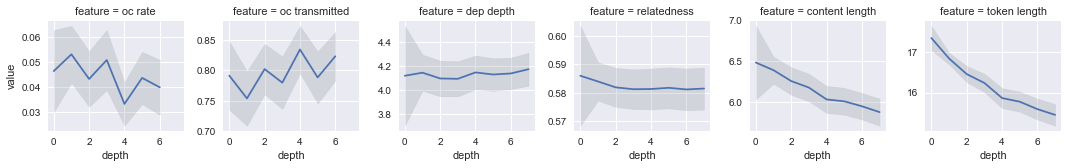

In [10]:
g = sb.FacetGrid(data=melted_data,
                 dropna=False, col='feature', col_order=features+length_features,
                 col_wrap=6, size=2.5, sharey=False)
g.map_dataframe(plot_feature_evolution, 'depth', 'value')

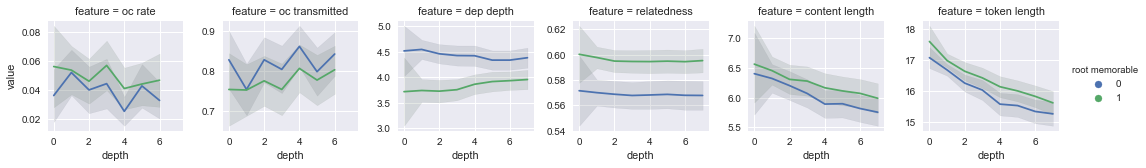

In [11]:
g = sb.FacetGrid(data=melted_data,
                 dropna=False, col='feature', col_order=features+length_features,
                 hue='root memorable',
                 col_wrap=6, size=2.5, sharey=False)
g.map_dataframe(plot_feature_evolution, 'depth', 'value').add_legend()

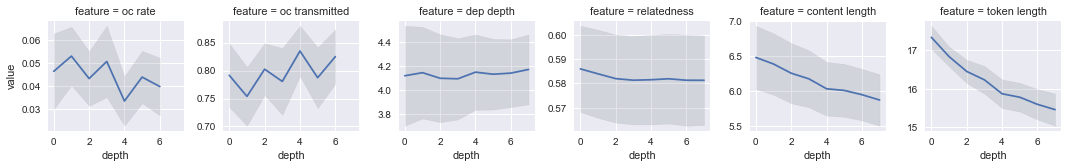

In [12]:
g = sb.FacetGrid(data=melted_data
                     .groupby(['tree id', 'depth', 'feature'], as_index=False)
                     ['tree id', 'depth', 'feature', 'value']
                     .mean(),
                 dropna=False, col='feature', col_order=features+length_features,
                 col_wrap=6, size=2.5, sharey=False)
g.map_dataframe(plot_feature_evolution, 'depth', 'value')

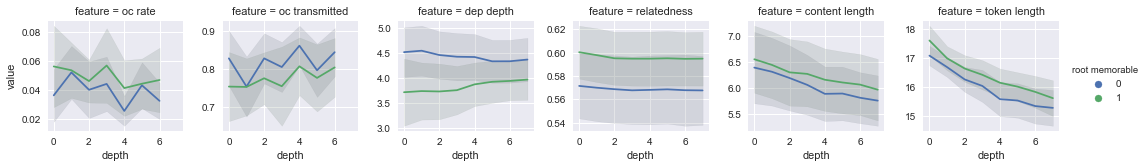

In [13]:
g = sb.FacetGrid(data=melted_data
                     .groupby(['tree id', 'depth', 'feature'], as_index=False)
                     ['tree id', 'depth', 'feature', 'value', 'root memorable']
                     .mean(),
                 dropna=False, col='feature', col_order=features+length_features,
                 hue='root memorable',
                 col_wrap=6, size=2.5, sharey=False)
g.map_dataframe(plot_feature_evolution, 'depth', 'value').add_legend()

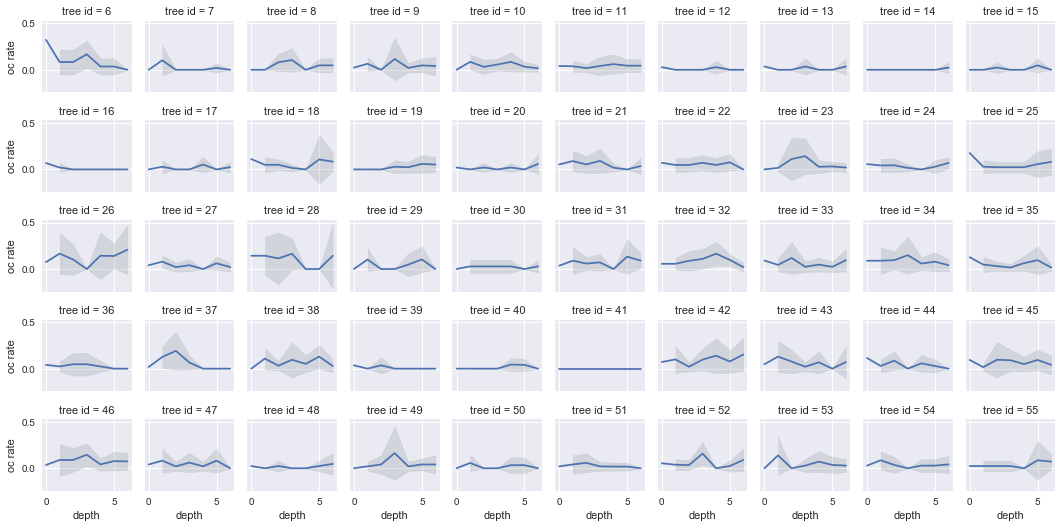

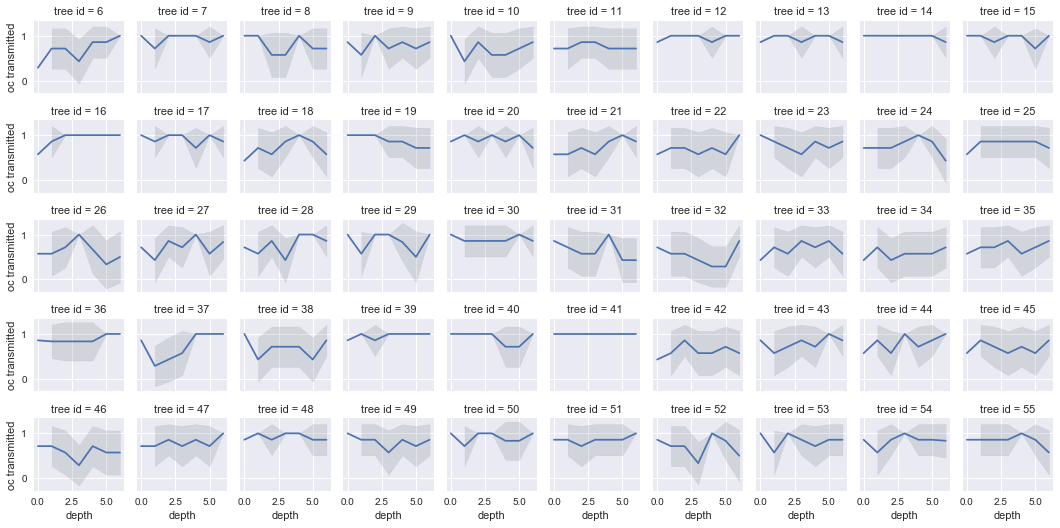

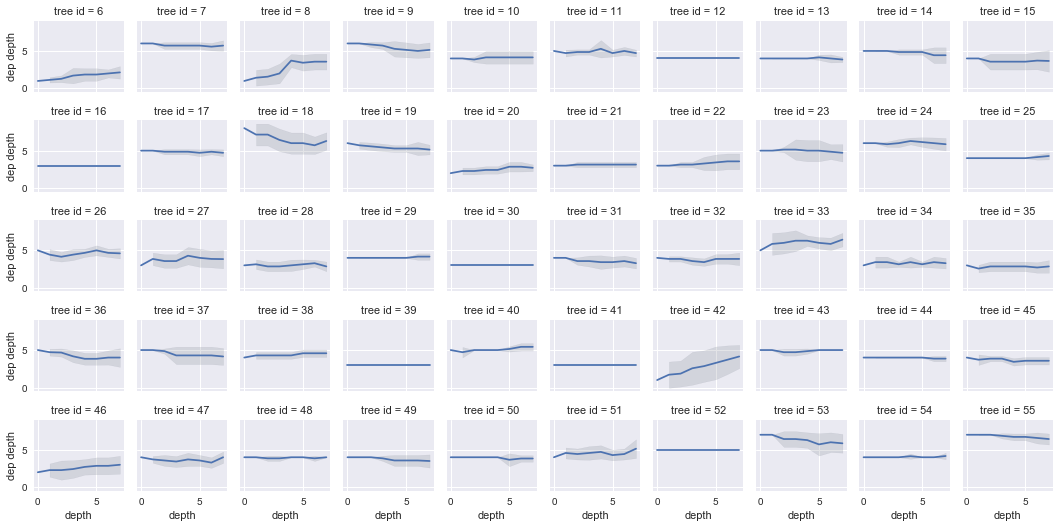

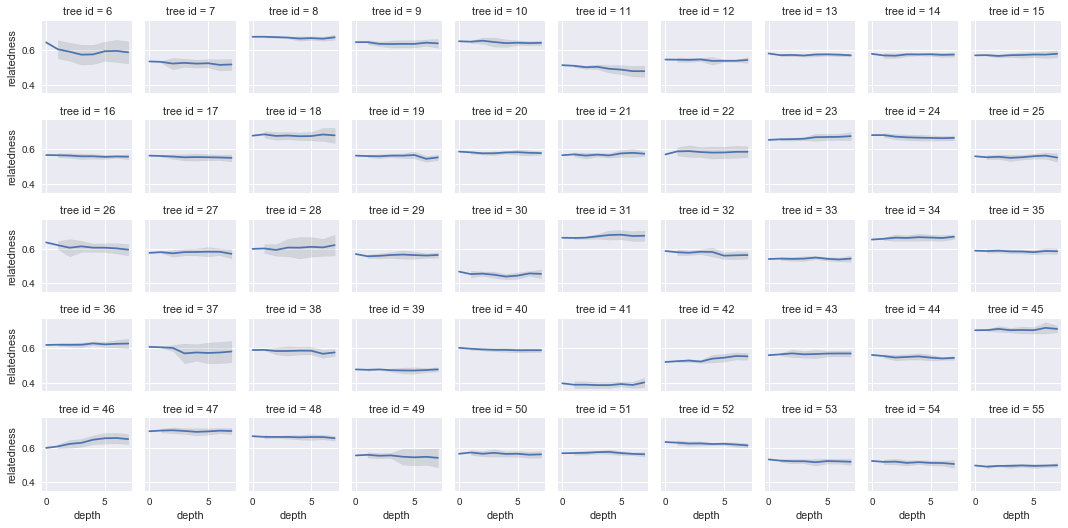

In [14]:
for feature in features:
    g = sb.FacetGrid(data=melted_data[melted_data.feature == feature],
                     dropna=False, col='tree id',
                     col_wrap=10, size=1.5)
    g.map_dataframe(plot_feature_evolution, 'depth', 'value')
    g.set_ylabels(feature)

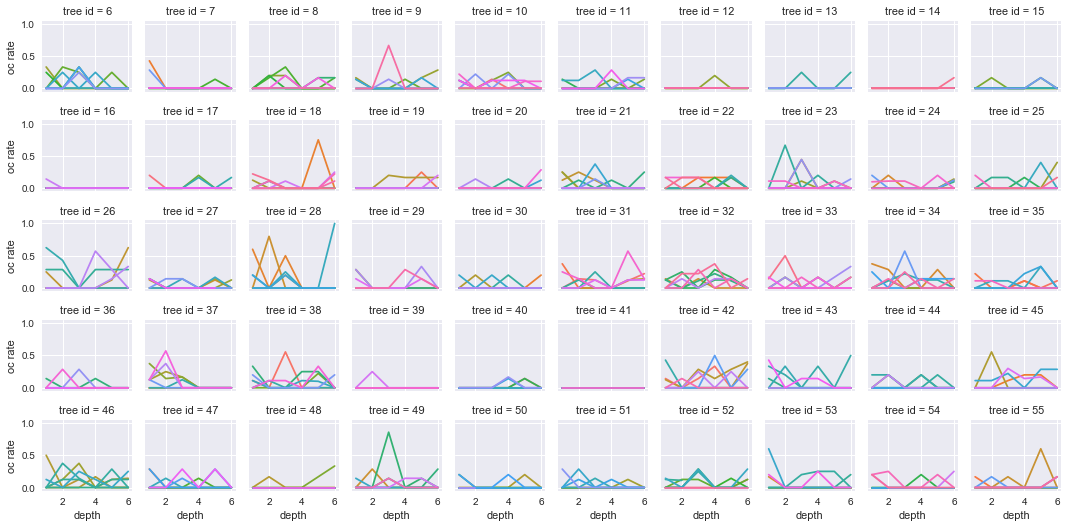

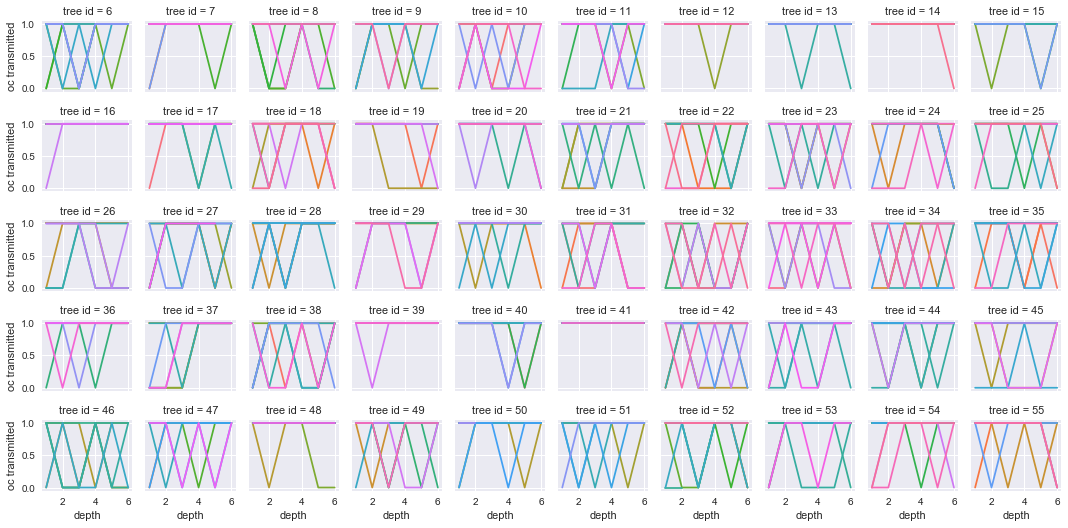

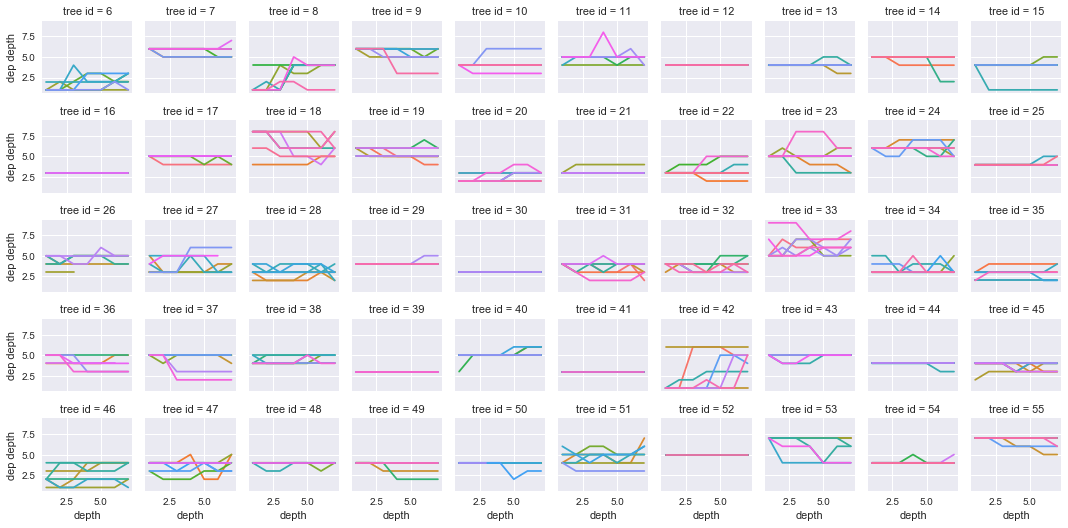

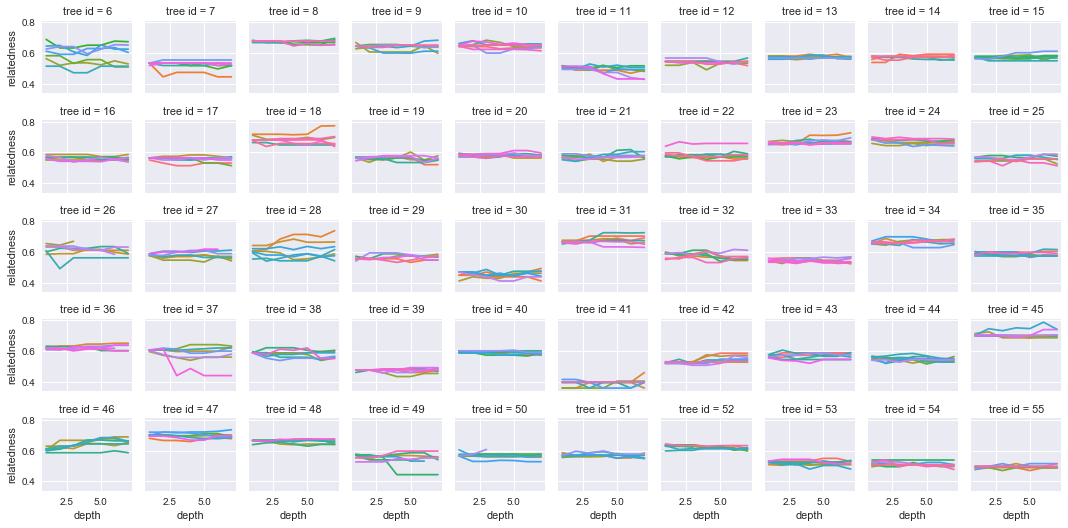

In [15]:
for feature in features:
    g = sb.FacetGrid(data=melted_data[melted_data.feature == feature],
                     dropna=False, col='tree id',
                     hue='branch id',
                     col_wrap=10, size=1.5)
    g.map_dataframe(plot_feature_evolution, 'depth', 'value')
    g.set_ylabels(feature)

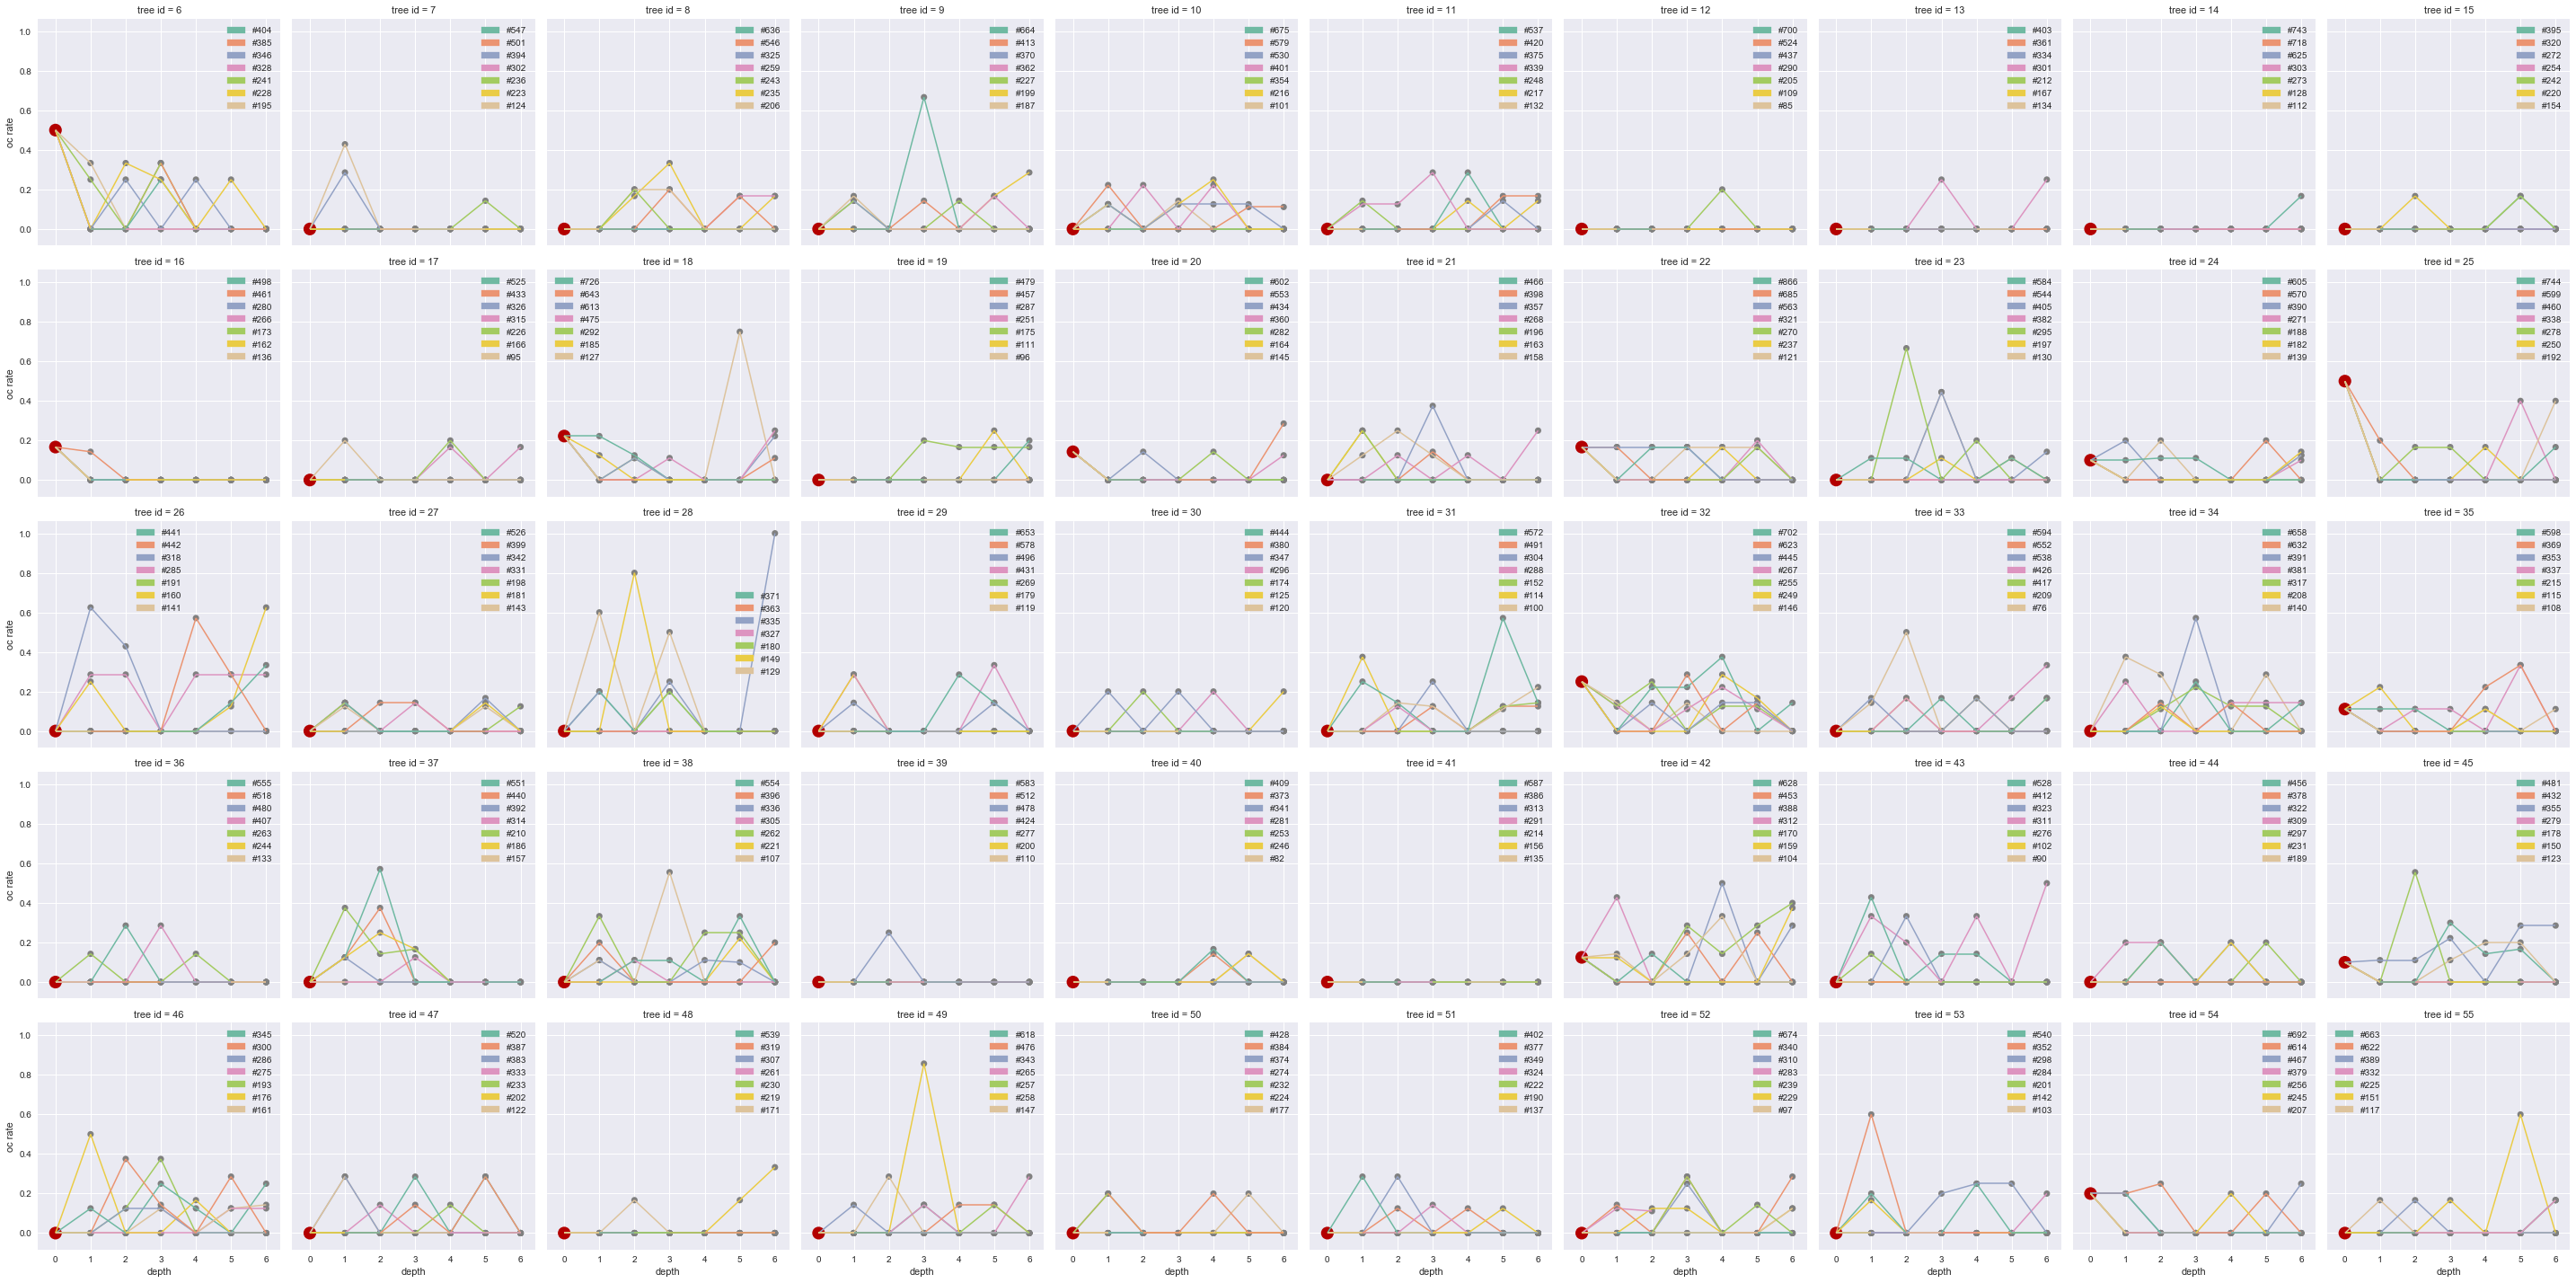

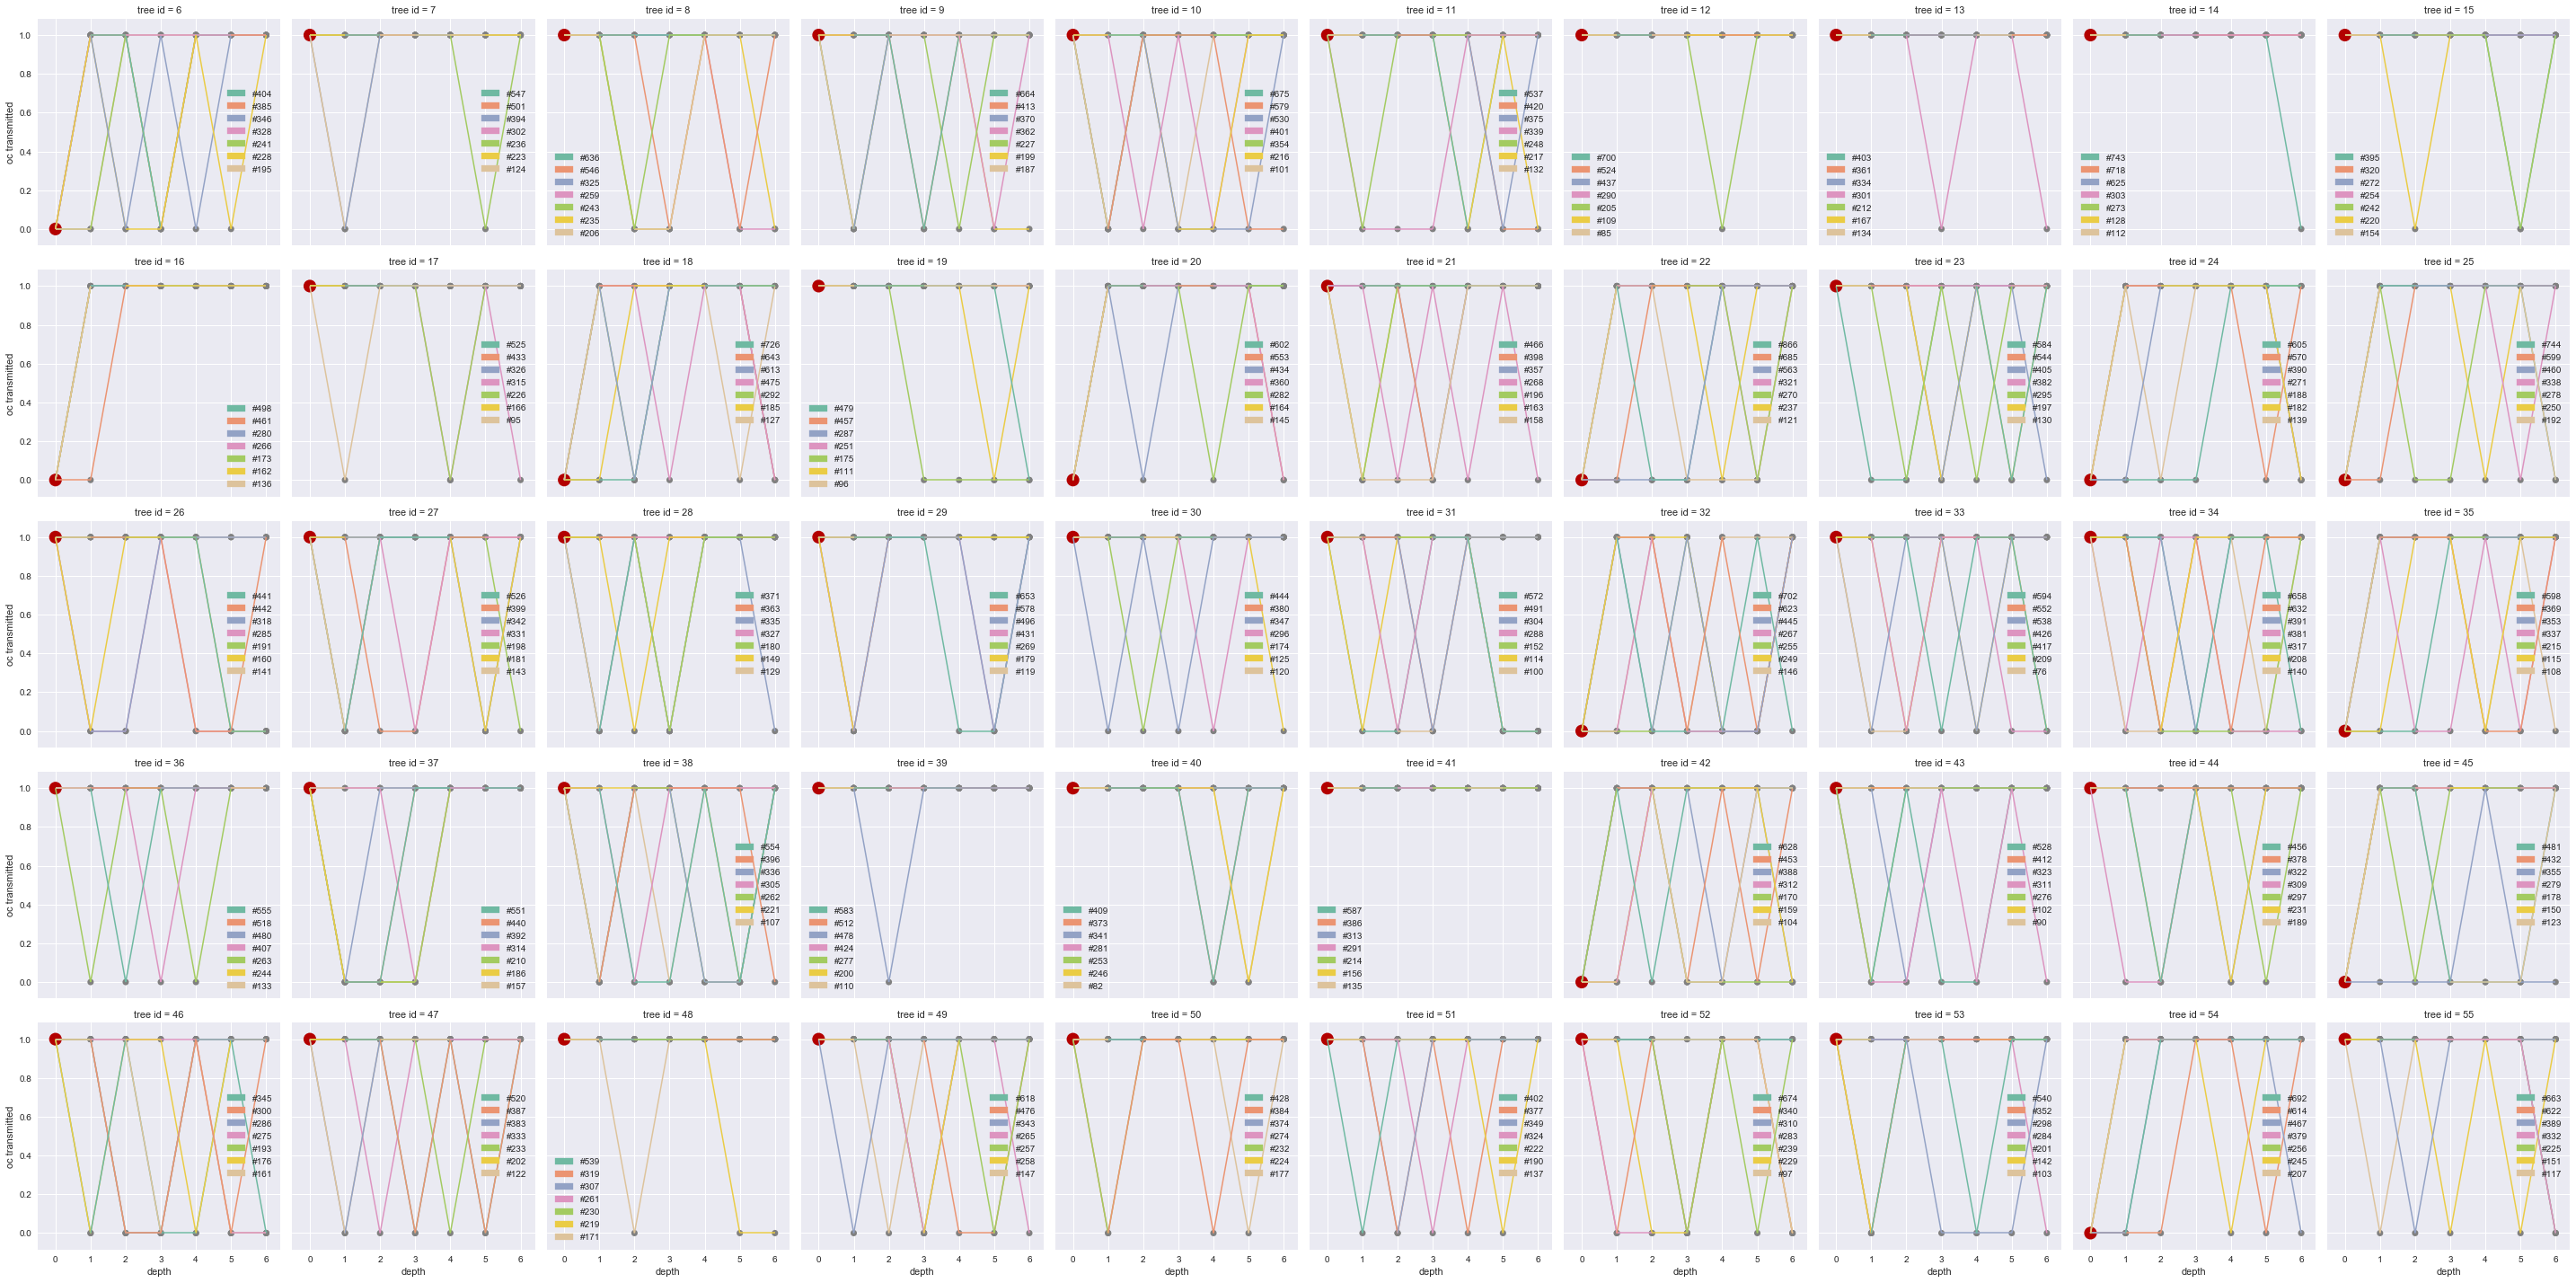

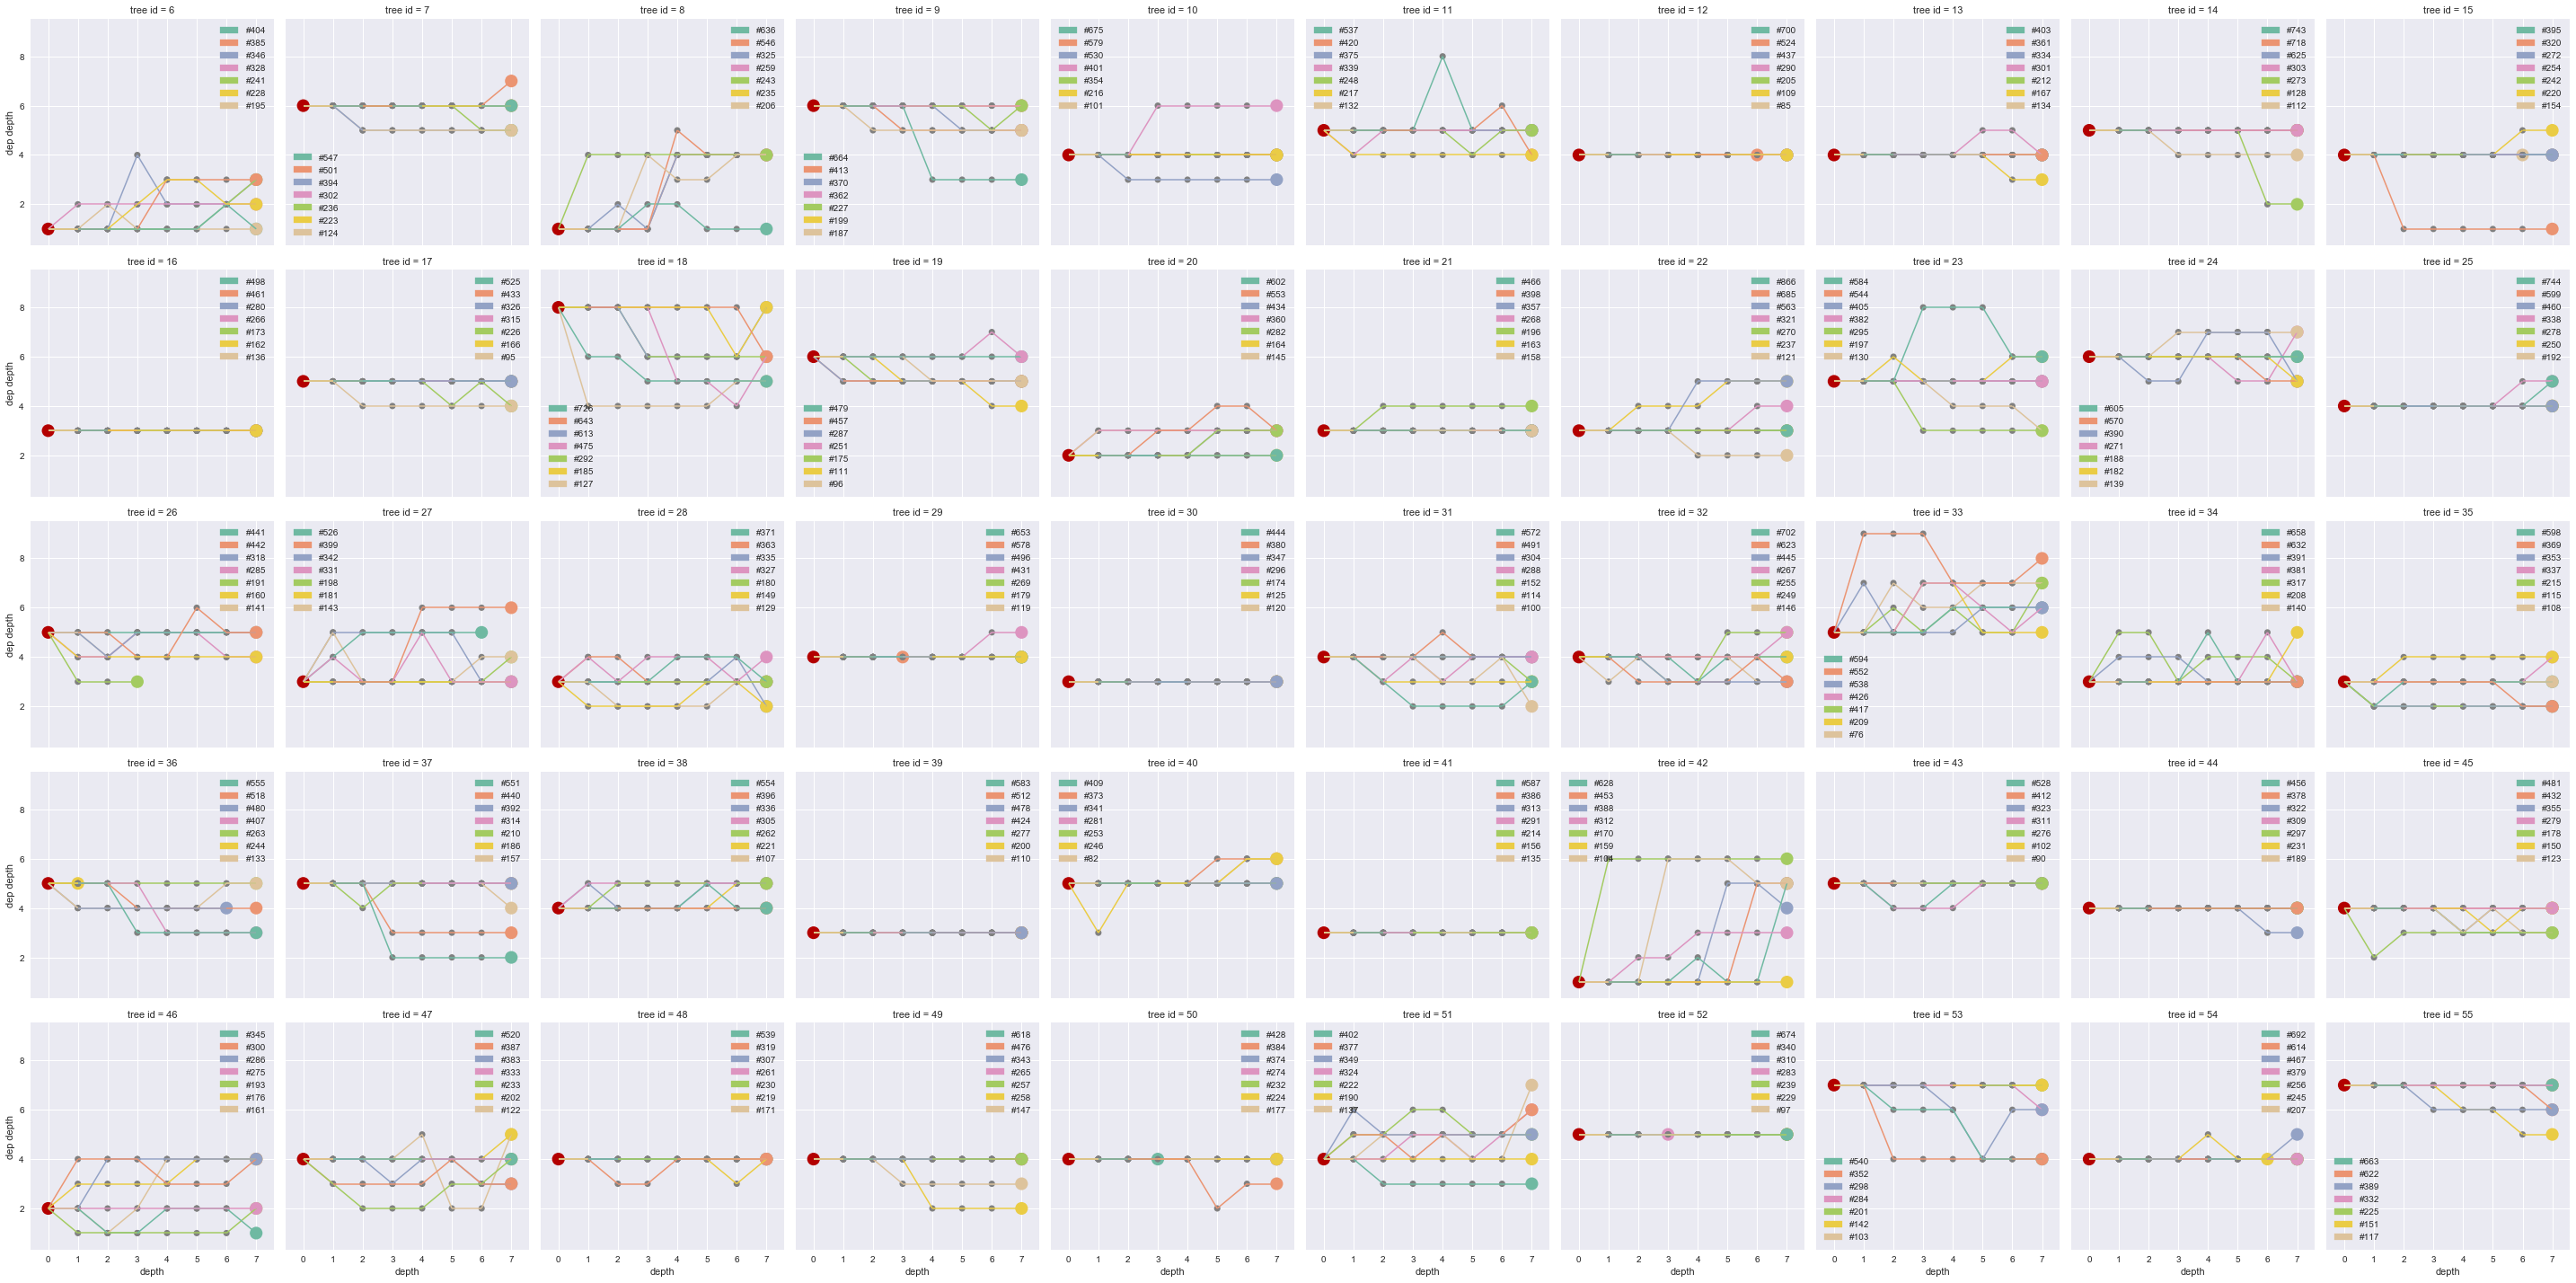

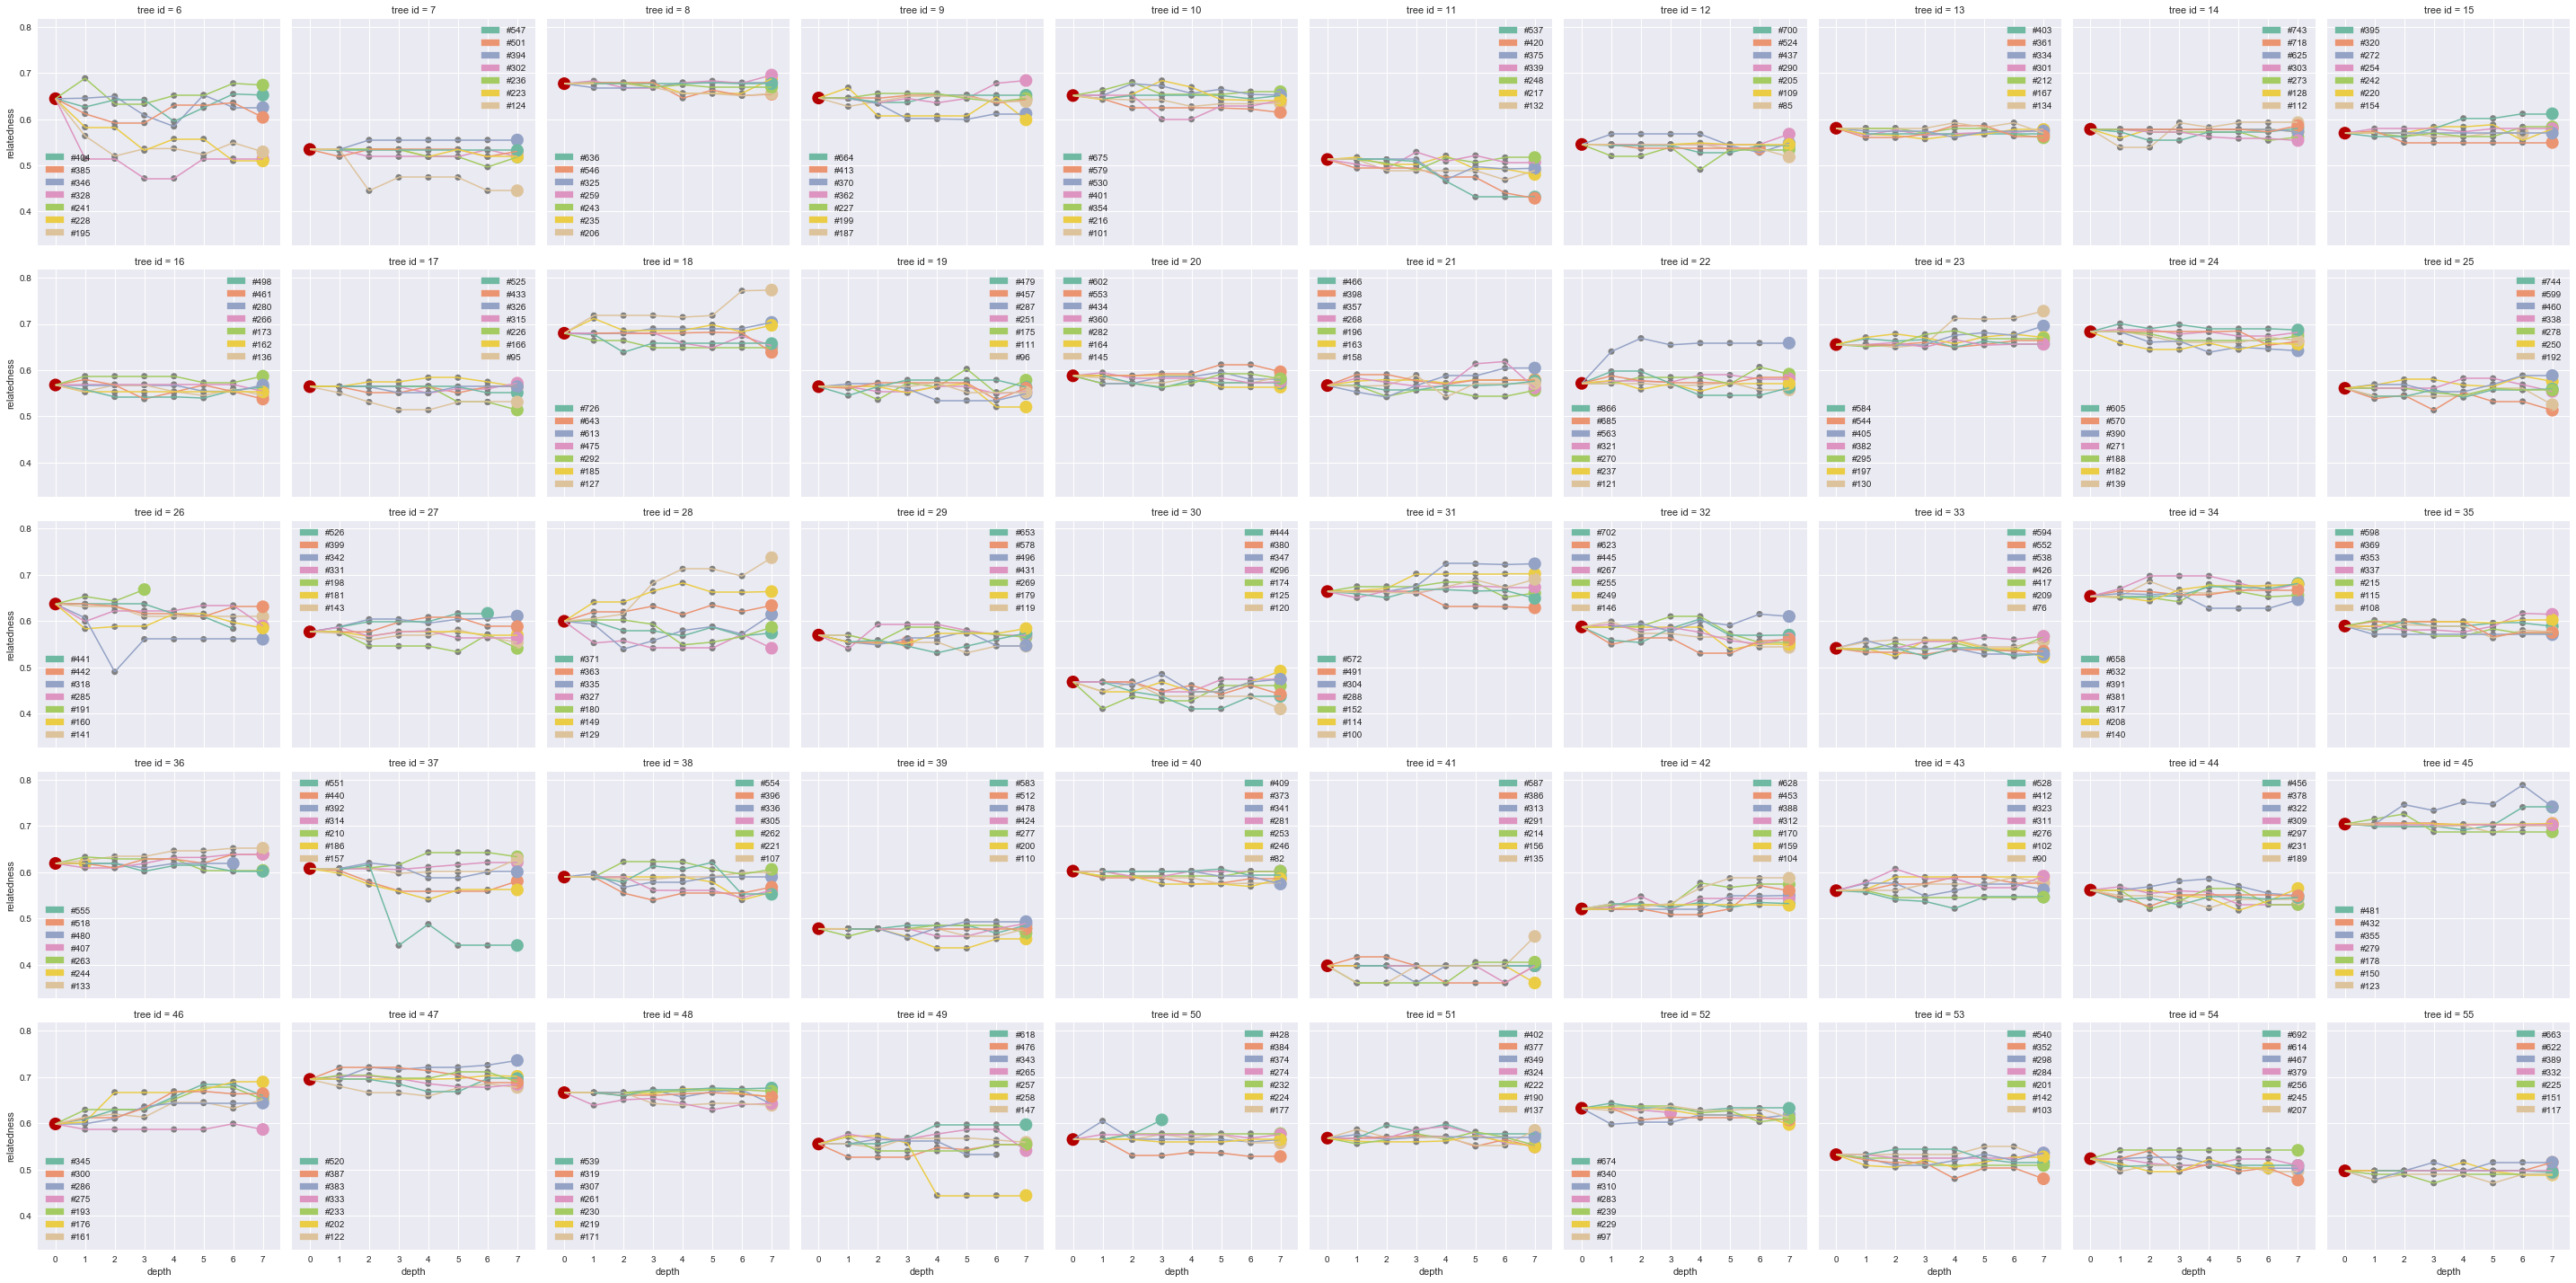

In [16]:
tree_ids = melted_data.groupby('sentence id')['tree id'].first()
for feature in features:
    legends = {}
    g = sb.FacetGrid(data=melted_data[melted_data.feature == feature]
                     .groupby('sentence id', as_index=False).first(),
                     dropna=False, col='tree id',
                     col_wrap=10, size=4)
    g.map_dataframe(plot_trajectories, 'depth', 'value', legends=legends)
    for i, ax in enumerate(g.axes):
        ax.legend(handles=legends[tree_ids.iloc[i]])
    g.set_ylabels(feature)

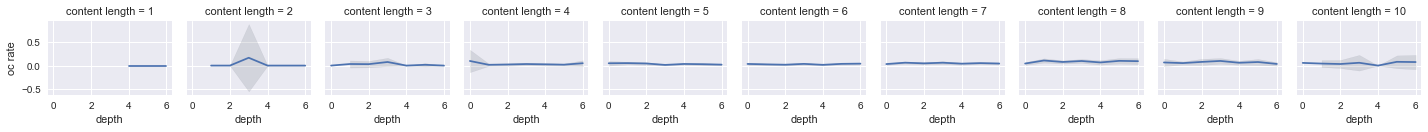

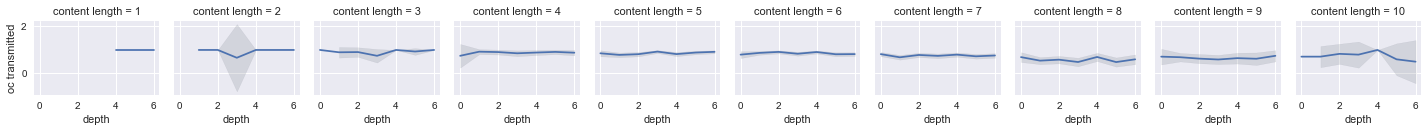

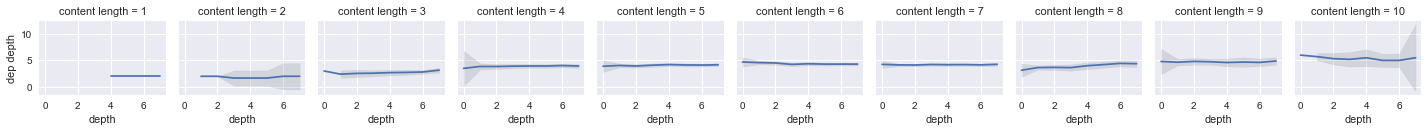

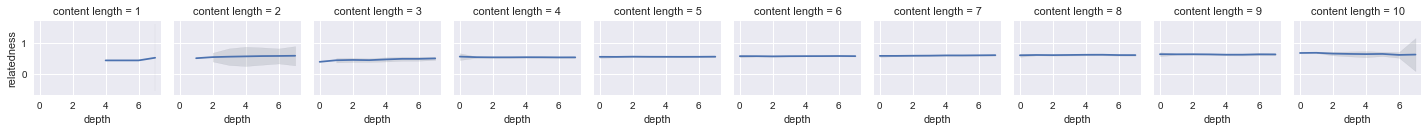

In [17]:
for feature in features:
    g = sb.FacetGrid(data=melted_data_lengths[melted_data_lengths.feature == feature],
                     dropna=False, col='content length',
                     col_wrap=10, size=2)
    g.map_dataframe(plot_feature_evolution, 'depth', 'value')
    g.set_ylabels(feature)

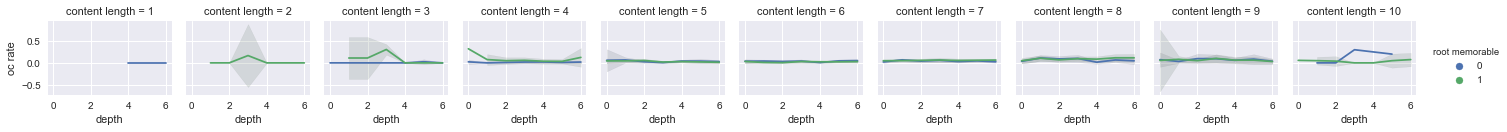

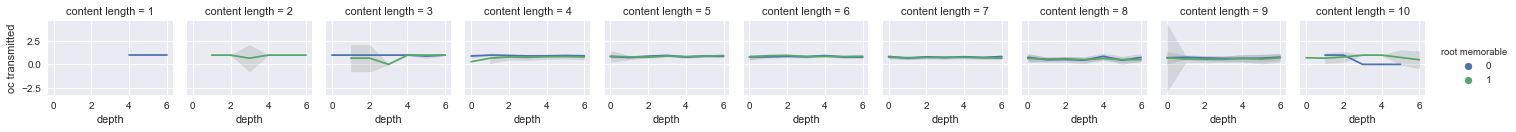

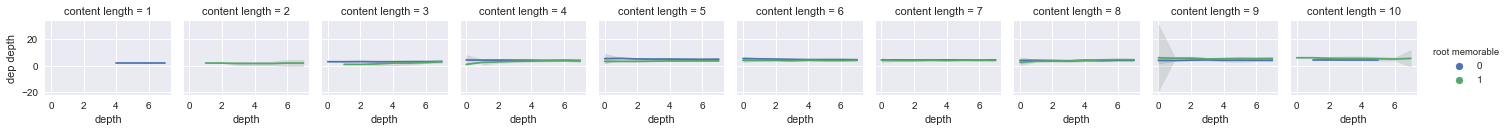

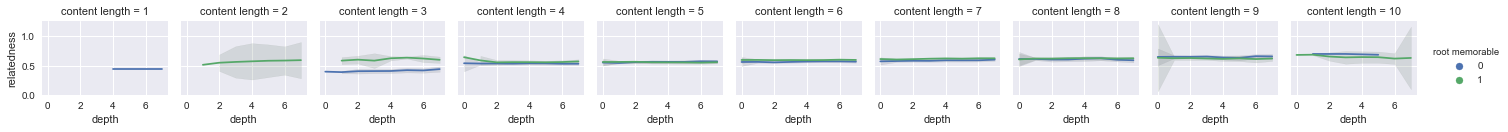

In [18]:
for feature in features:
    g = sb.FacetGrid(data=melted_data_lengths[melted_data_lengths.feature == feature],
                     dropna=False, col='content length',
                     hue='root memorable',
                     col_wrap=10, size=2)
    g.map_dataframe(plot_feature_evolution, 'depth', 'value').add_legend()
    g.set_ylabels(feature)

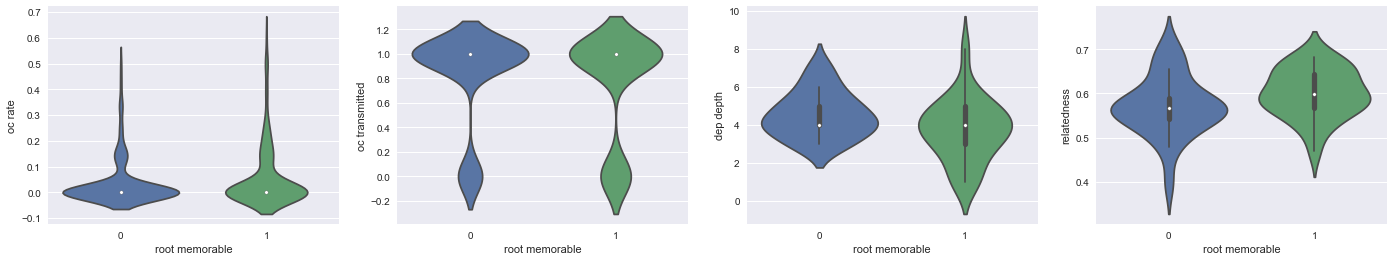

In [19]:
fig, axes = plt.subplots(1, len(features), figsize=(6 * len(features), 4))
for i, feature in enumerate(features):
    ids = melted_data_lengths['is root'] & (melted_data_lengths.feature == feature)
    # Use a violinplot in a for loop, instead of a factorplot/FacetGrid,
    # since the behaviour for repeated measures is different according to the feature
    sb.violinplot(ax=axes[i], y='value', x='root memorable',
                  data=(melted_data_lengths[ids]
                        if ('rate' in feature) or ('transmitted' in feature)
                        # For non transmission-related features, remove repeated measures
                        else melted_data_lengths[ids].groupby('sentence id').first()),
                  size=3)
    axes[i].set_ylabel(feature)

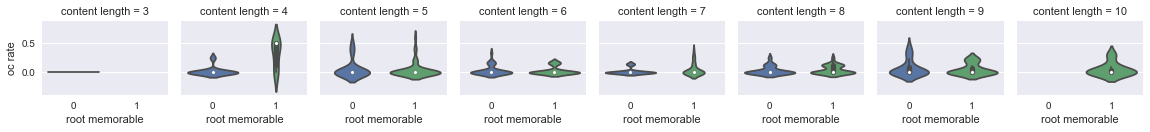

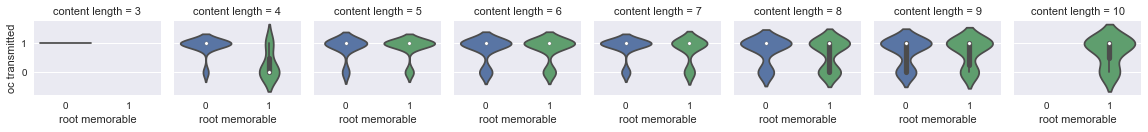

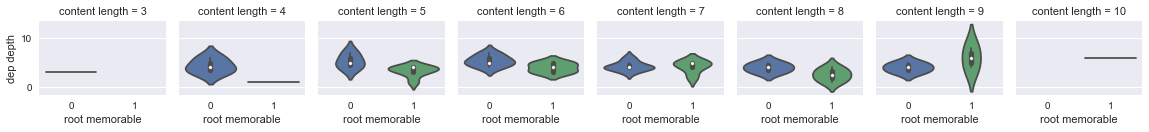

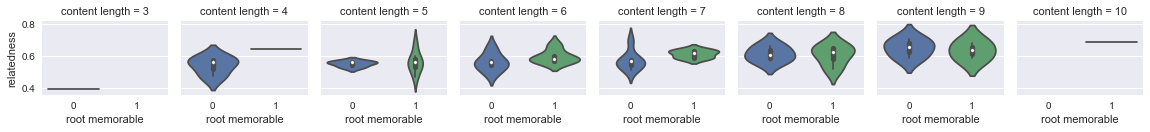

In [20]:
for feature in features:
    ids = melted_data_lengths['is root'] & (melted_data_lengths.feature == feature)
    g = sb.factorplot(y='value', x='root memorable',
                      data=(melted_data_lengths[ids]
                            if ('rate' in feature) or ('transmitted' in feature)
                            # For non transmission-related features, remove repeated measures
                            else melted_data_lengths[ids].groupby('sentence id').first()),
                      kind='violin',
                      col='content length', col_wrap=10,
                      size=2)
    g.set_ylabels(feature)

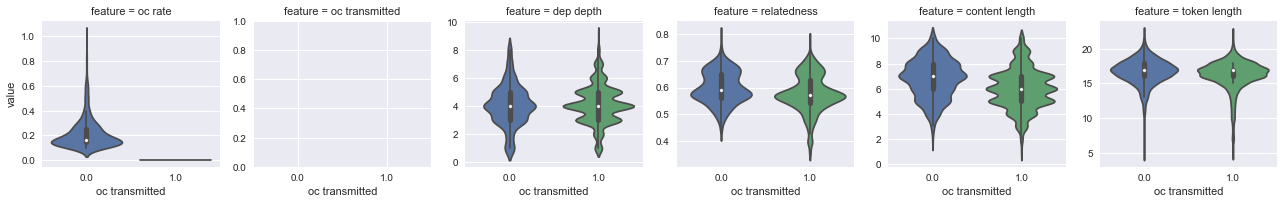

In [21]:
sb.factorplot(y='value', x='oc transmitted',
              data=melted_data_transmitted,
              col='feature', col_order=features+length_features,
              sharey=False,
              kind='violin', size=3)

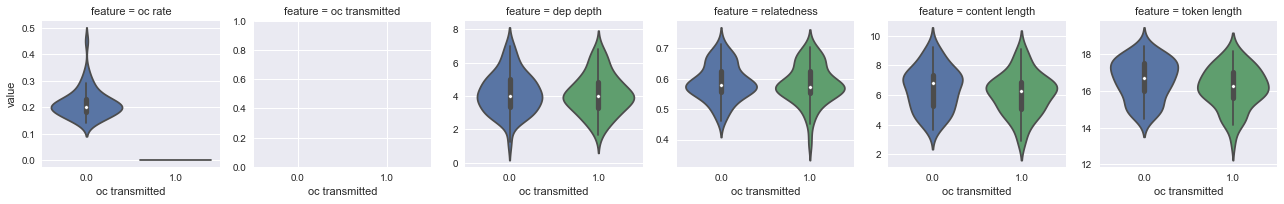

In [22]:
sb.factorplot(y='value', x='oc transmitted',
              data=melted_data_transmitted
              .groupby(['tree id', 'oc transmitted', 'feature'], as_index=False)
                     ['tree id', 'oc transmitted', 'feature', 'value']
                     .mean(),
              col='feature', col_order=features+length_features,
              sharey=False,
              kind='violin', size=3)

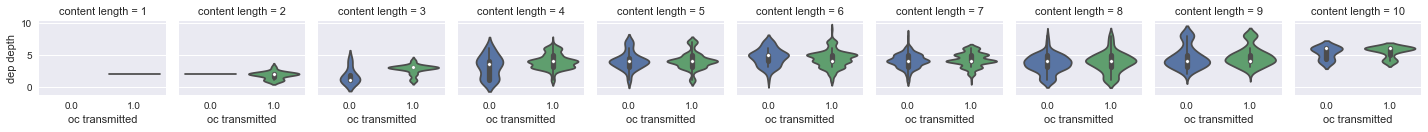

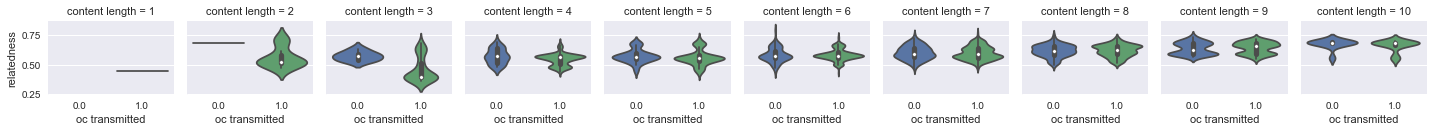

In [23]:
for feature in features:
    if 'transmitted' in feature or 'rate' in feature:
        continue
    g = sb.factorplot(y='value', x='oc transmitted',
                      data=melted_data_transmitted_lengths[melted_data_transmitted_lengths.feature == feature],
                      col='content length', col_wrap=10,
                      kind='violin', size=2)
    g.set_ylabels(feature)

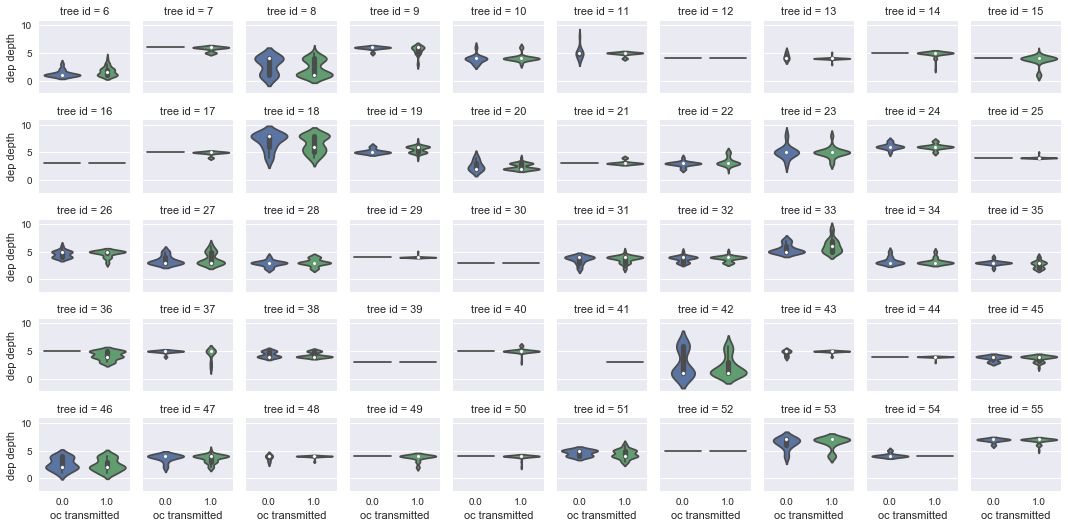

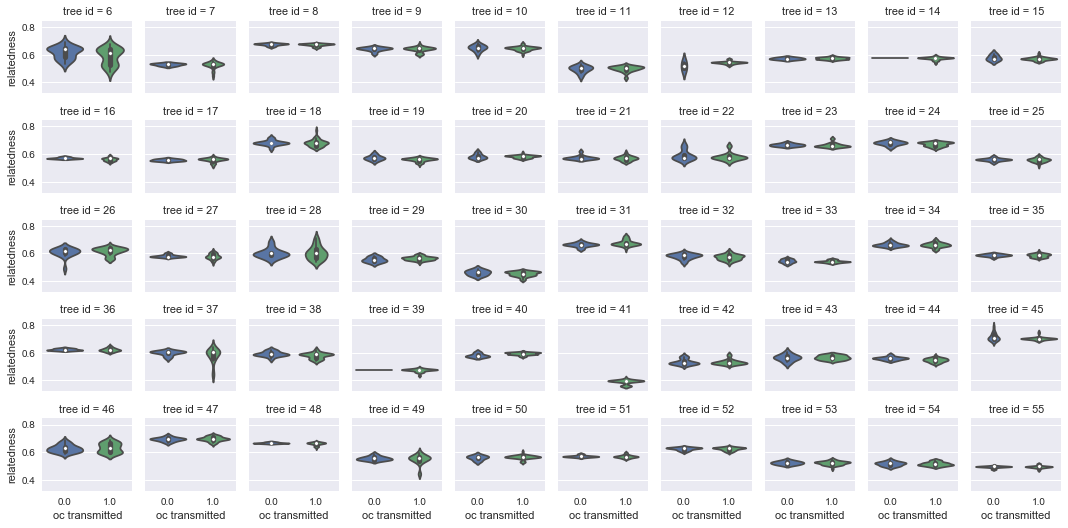

In [24]:
for feature in features:
    if 'transmitted' in feature or 'rate' in feature:
        continue
    g = sb.factorplot(y='value', x='oc transmitted',
                      data=melted_data_transmitted_lengths[melted_data_transmitted_lengths.feature == feature],
                      col='tree id', col_wrap=10,
                      kind='violin', size=1.5)
    g.set_ylabels(feature)

TODO: to implement variability graphs, we need CIs on the standard deviation, to be implemented following [Bonnet (2006)](https://pdfs.semanticscholar.org/2488/129d6d00cd42361cf30f03e1abae3ac717de.pdf) ([Cho, Cho, & Eltinge (2005)](http://www.ijpam.eu/contents/2005-21-3/10/10.pdf) might also be useful). It's not trivial, so I won't be doing it soon.

## 3 Sentence feature step-change

In [25]:
data = []
for tree in Tree.objects.experiment:
    for sentence in tree.sentences.kept:
        sentence_depth = sentence.depth
        if sentence_depth > config.target_branch_depth:
            # Ignore out-of-shape sentences
            continue
        doc = nlp(sentence.text)
        children = sentence.children.kept
        doc_dep_depth = dep_depth(doc)
        content_length = len(sentence.content_words)
        token_length = len(doc)
        for child in children:
            if child.depth > config.target_branch_depth:
                continue
            oc_rate = sentence.ordered_content_distance(child)
            child_doc = nlp(child.text)
            data.append({
                'tree id': tree.id,
                'branch id': child.head.id,
                'parent depth': sentence_depth,
                'root memorable': int(tree.id % 2 == 0),
                'oc transmitted': int(oc_rate == 0),

                'parent id': sentence.id,
                'parent dep depth': doc_dep_depth,
                'parent content length': content_length,
                'parent token length': token_length,
                'parent relatedness': relatedness(doc),

                'child id': child.id,
                'child dep depth': dep_depth(child_doc),
                'child content length': len(child.content_words),
                'child token length': len(child_doc),
                'child relatedness': relatedness(child_doc),
            })

features = ['dep depth', 'relatedness']
continuous_features = ['relatedness']
length_features = ['content length', 'token length']
data = pd.DataFrame(data)

In [26]:
def plot_variation(**kwargs):
    data = kwargs.pop('data')
    ax = kwargs.get('ax', plt.gca())
    color = kwargs.get('color', sb.color_palette()[0])
    feature = kwargs['feature']
    binning = kwargs.get('binning')
    x = data['parent ' + feature]
    y = data['child ' + feature]
    
    # Compute binning.
    if binning is not None:
        for bin_count in range(binning, 0, -1):
            try:
                x_bins, bins = pd.cut(x, bin_count, labels=False,
                                      retbins=True, right=False)
                break
            except ValueError:
                pass
        middles = (bins[:-1] + bins[1:]) / 2
    else:
        middles = np.arange(x.values.min(), x.values.max() + 1)
        x_bins = x.values - x.values.min()
        bin_count = len(middles)
    
    # Compute bin values.
    values = np.zeros(bin_count)
    cis = np.zeros(bin_count)
    for i in range(bin_count):
        indices = x_bins == i
        n = indices.sum()
        values[i] = y[indices].mean()
        cis[i] = (stats.t.ppf(1 - 0.5/2, n - 1) * y[indices].std(ddof=1)
                  / np.sqrt(n))
    
    # Plot.
    ax.plot(middles, values, '-', lw=2, color=color)
    ax.fill_between(middles, values - cis, values + cis,
                    color=sb.desaturate(color, 0.2), alpha=0.2)
    ax.plot(middles, middles, linestyle='dotted',
            color=sb.desaturate(color, 0.2))

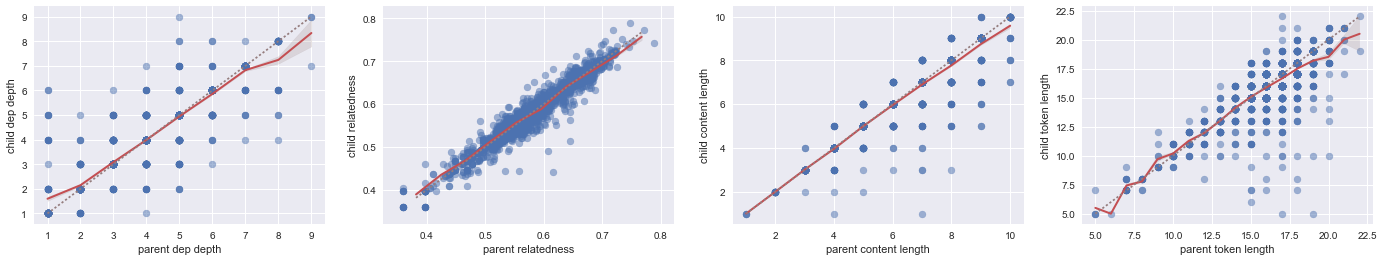

In [27]:
fig, axes = plt.subplots(1, len(features + length_features),
                         figsize=(6 * len(features + length_features), 4))
for i, feature in enumerate(features + length_features):
    axes[i].scatter(data['parent ' + feature], data['child ' + feature],
                    color=sb.color_palette()[0] + (0.5,))
    plot_variation(data=data, feature=feature, ax=axes[i], color=sb.color_palette()[2],
                   binning=10 if feature in continuous_features else None)
    axes[i].set_xlabel('parent ' + feature)
    axes[i].set_ylabel('child ' + feature)

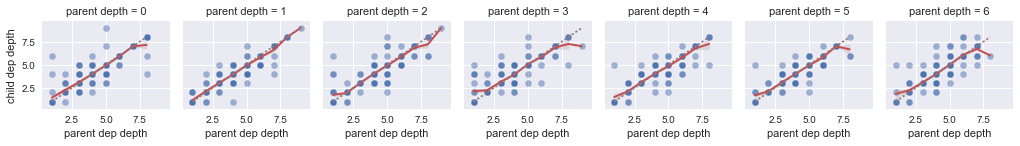

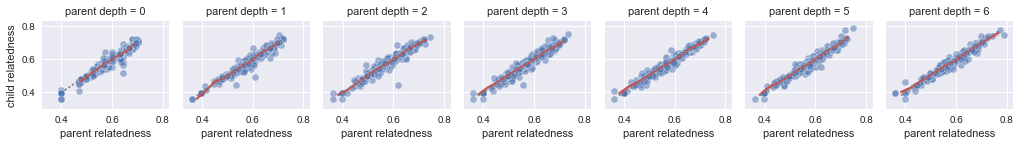

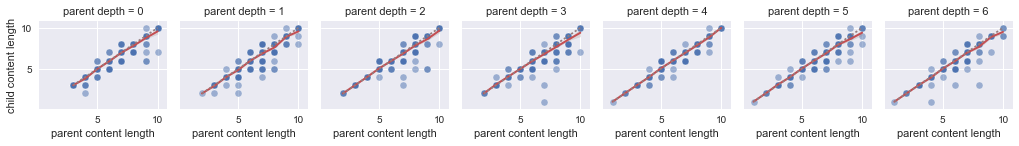

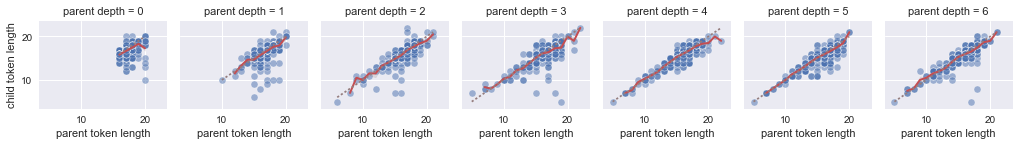

In [28]:
for feature in features + length_features:
    g = sb.FacetGrid(data=data,
                     dropna=False, col='parent depth',
                     col_wrap=10, size=2)
    g.map(plt.scatter, 'parent ' + feature, 'child ' + feature,
          alpha=.5, linewidth=.5, edgecolor="white")
    g.map_dataframe(plot_variation, feature=feature, color=sb.color_palette()[2],
                    binning=10 if feature in continuous_features else None)
    g.set_xlabels('parent ' + feature)
    g.set_ylabels('child ' + feature)

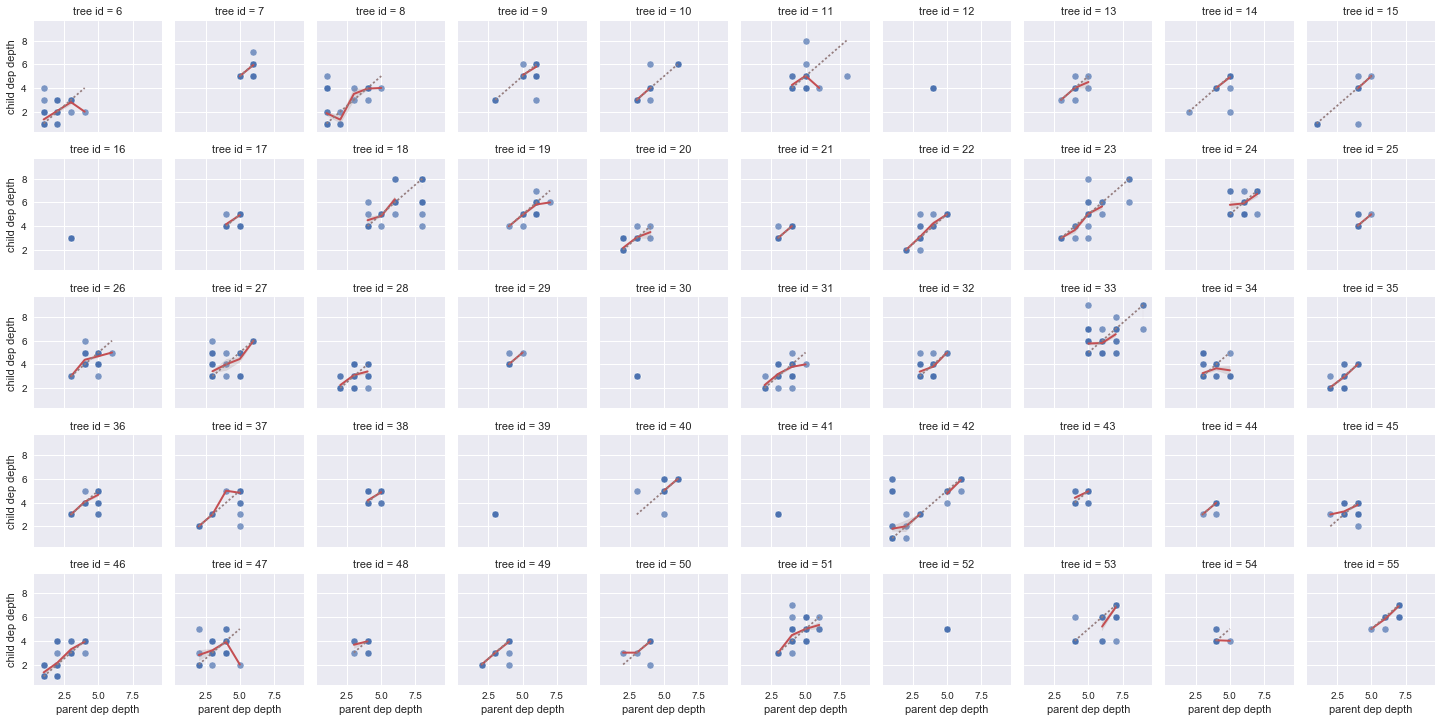

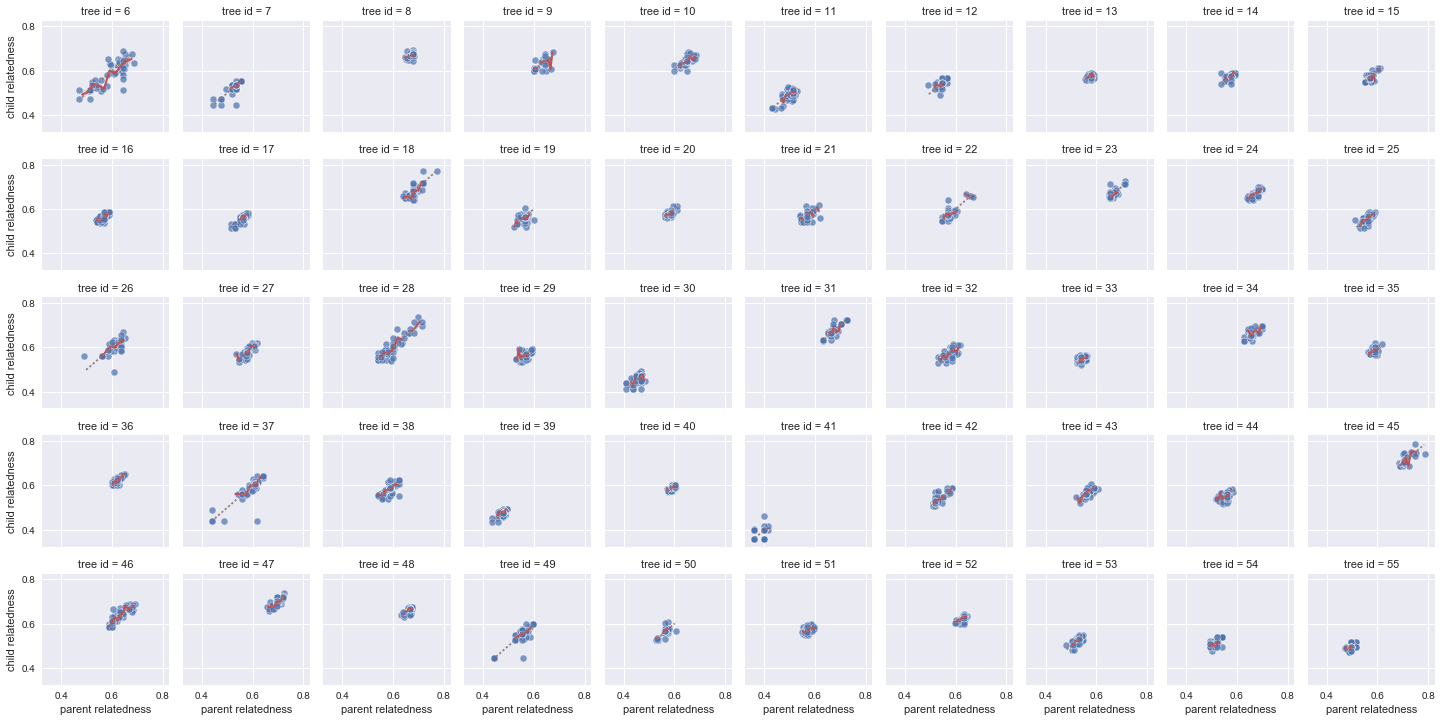

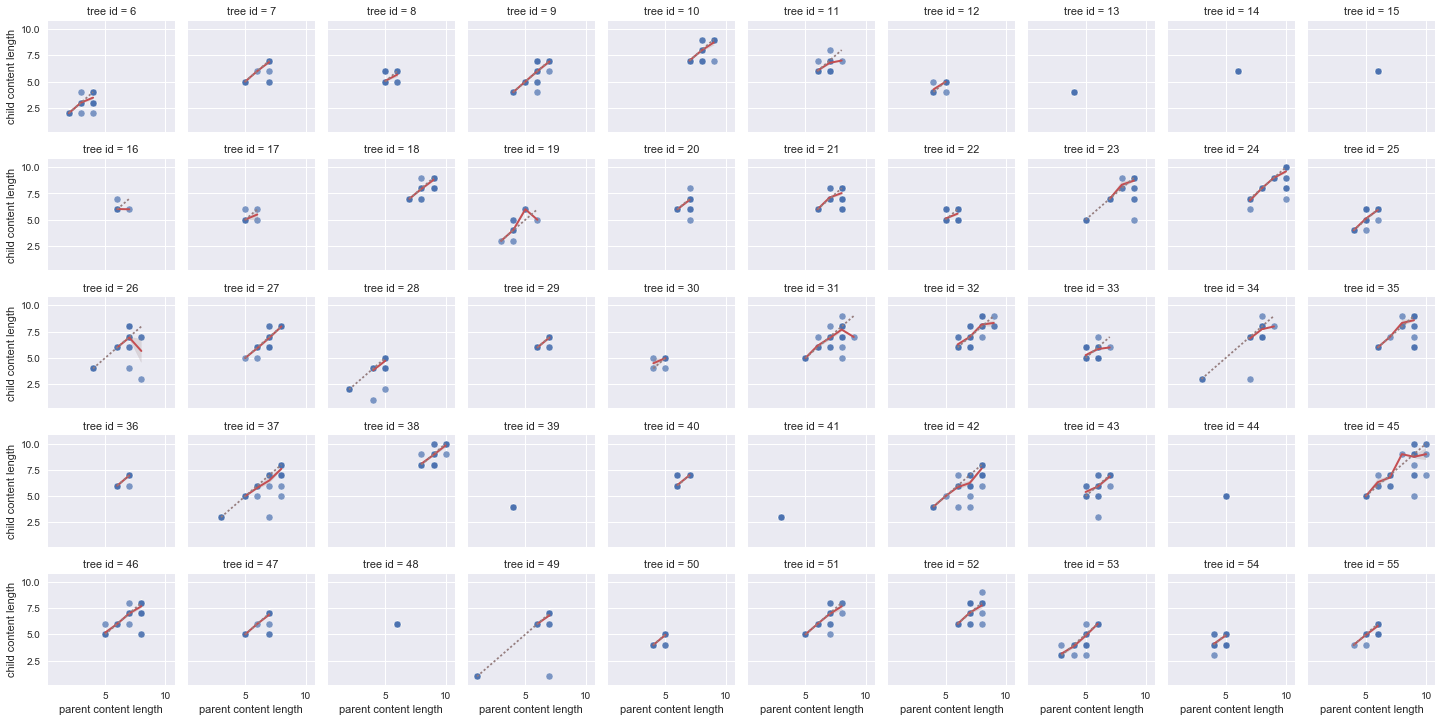

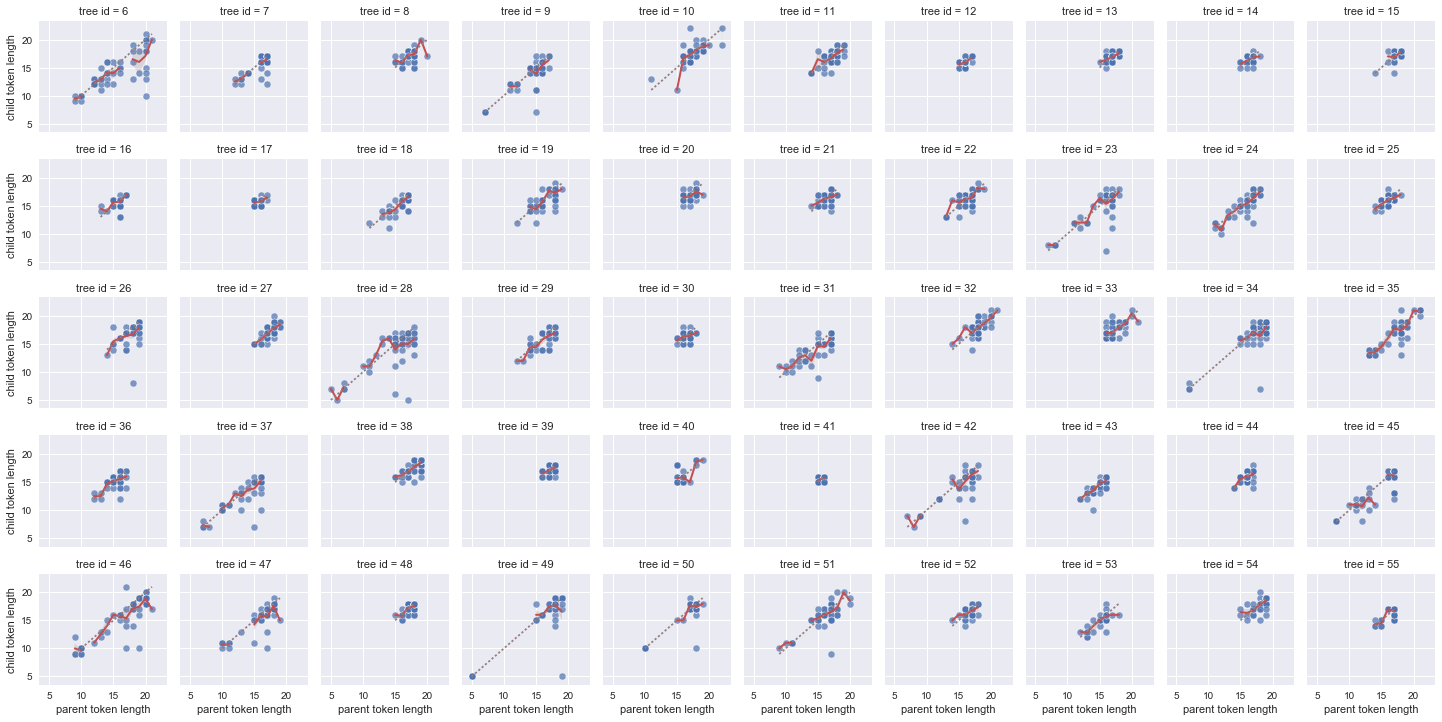

In [29]:
for feature in features + length_features:
    g = sb.FacetGrid(data=data,
                     dropna=False, col='tree id',
                     col_wrap=10, size=2)
    g.map(plt.scatter, 'parent ' + feature, 'child ' + feature,
          alpha=.7, linewidth=.5, edgecolor="white")
    g.map_dataframe(plot_variation, feature=feature, color=sb.color_palette()[2],
                    binning=10 if feature in continuous_features else None)
    g.set_xlabels('parent ' + feature)
    g.set_ylabels('child ' + feature)

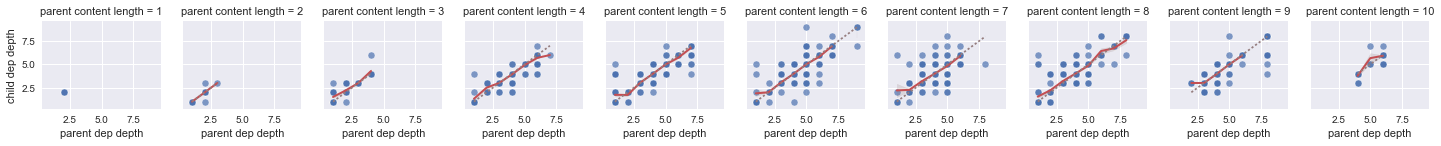

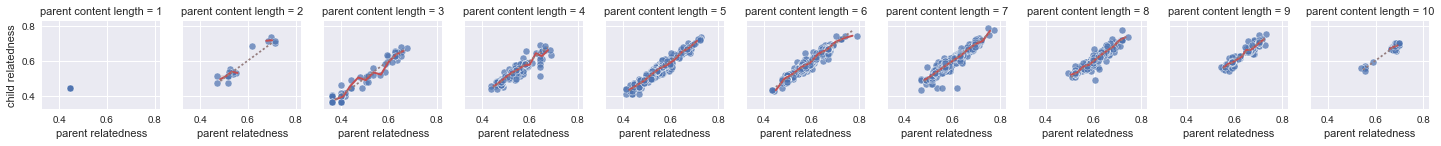

In [30]:
for feature in features:
    g = sb.FacetGrid(data=data,
                     dropna=False, col='parent content length',
                     col_wrap=10, size=2)
    g.map(plt.scatter, 'parent ' + feature, 'child ' + feature,
          alpha=.7, linewidth=.5, edgecolor="white")
    g.map_dataframe(plot_variation, feature=feature, color=sb.color_palette()[2],
                    binning=10 if feature in continuous_features else None)
    g.set_xlabels('parent ' + feature)
    g.set_ylabels('child ' + feature)